In [1]:
import numpy as np
from scipy import stats
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import os
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import sys
import glob
import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import Image
import imageio

# ----------------------------------------------
# ######## En local ############
path_dir = os.getcwd()
from config.utils import *
# ##############################
# ----------------------------------------------
#                    ou
# ----------------------------------------------
# ######### En colab #############
# from google.colab import drive
# drive.mount('/content/drive')

# # ********** A modifier ************
# MY_PATH = "TP-GAN"
# #************************************
# path_dir = os.path.join("/content/drive/My Drive", MY_PATH)
# sys.path.append(os.path.join(path_dir, "config"))
# from utils import *
# ################################
# ----------------------------------------------

print("TF version: ", tf.__version__)  # verifier d'avoir la version 2.3.0

%load_ext autoreload
%autoreload 2

TF version:  2.3.1


# Distribution normale univariée et sa fonction quantile
On se donne un échantillon de tirages i.i.d. $\{x_i \in \mathbb R \}_{i=1}^n$ de la loi normale standard $\mathcal N(0,1)$. Pour cela, il est possible soit de simuler ces données directement à partir la librairie [numpy](https://https://numpydoc.readthedocs.io/en/latest/format.html#docstring-standard), par exemple avec la fonction _numpy.random.randn_, soit de générer des tirages d'une loi uniforme sur $[0,1]$ et passer ensuite par l'inverse de la fonction de répartition $\Phi^{-1}(u) = \inf\{ x\in \mathbb R: u\leq \Phi(x)\}$, où $\Phi$ est la fonction de répartition (cdf en anglais) de la loi $\mathcal N(0,1)$. Parmi les méthodes de la librairie [scipy](https://docs.scipy.org/doc/scipy/reference/stats.html), la fonction **ppf** (*percent point function*) désigne la fonction inverse de la cdf.  

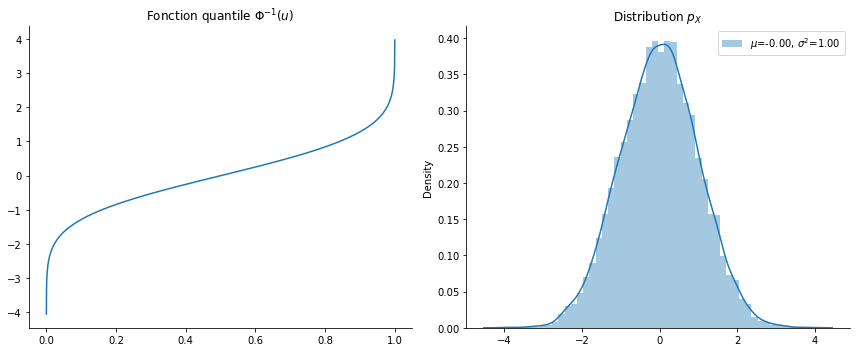

In [2]:
# information sur les données
np.random.seed(1234)
N_DATA = 10000
DATA_DIM = 1

# N_DATA tirages uniformes iid
uniform = np.random.uniform(size=(N_DATA, DATA_DIM))

# On transforme en N_DATA tirages gaussiens iid en appliquant l'inverse
# de la fct de répartition
dataset_train = stats.norm.ppf(uniform).astype(np.float32)

# La fonction viz_gaussian_train a été importée du fichier config.utils.py
# Elle permet d'obtenir l'affichage de la fonction stats.norm.ppf et de la distribution empirique
# des données, comme ci-dessous
viz_gaussian_train(uniform, dataset_train)

In [3]:
# sauvegarder et charger les données

save_data_gaussian(dataset=dataset_train, path_dir=path_dir)
# load_data_gaussian(n_data=N_DATA, path_dir=path_dir)

## Implémentation

**Pseudo-code**:

Le pseudo-code d'entrainement d'un GAN, cours 5.

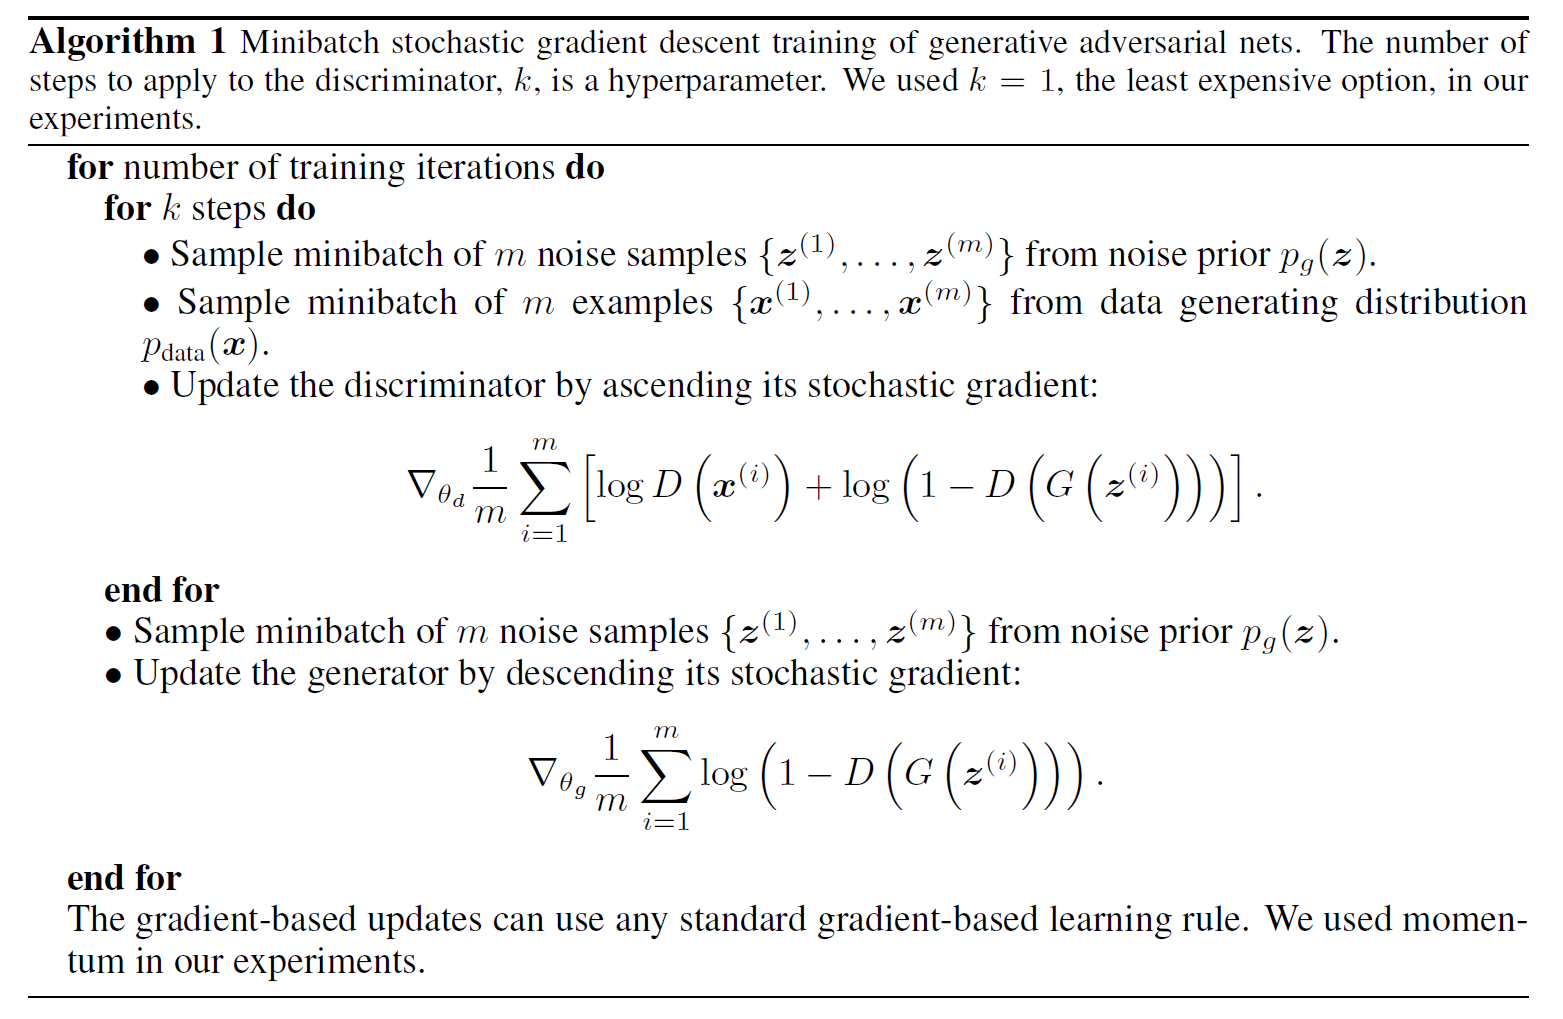

In [4]:
Image(filename=os.path.join(path_dir, "config", "screen", "pseudo_code_GAN.jpg"), width=700, height=500)

Il faut faire un choix des fonctions d'activation qui apparaissent dans le générateur et dans le discriminateur: dans la suite, nous utiliserons la fonction d'activation Leaky ReLU $\sigma$:
$$\sigma(x)=\max(\alpha x, x), \quad \alpha>0.$$

### Generator

In [5]:
def build_generator(latent_dim, n_neurons, data_dim=DATA_DIM):
    """
    Construction du générateur
    
    Parameters
    ----------
    latent_dim: int
        Dimension de la variable latente
    n_neurons: int
        Nombre de neurones dans la couche cachée
    data_dim: int
        Dimension de l'espace des données 

    Returns
    -------
    tf.Model
        Générateur du GAN
    """    
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(n_neurons, input_shape=(latent_dim,), bias_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.2))
    # On utilise ici une fonction d'activation LeakyReLU : sigma(x) = ...
    # Vous pourrez tester d'autres exemples de fonction d'activation (e.g. ReLU, ou LeakyReLU avec 
    # d'autres valeurs de alpha) pour comparaison
    model.add(layers.Dense(n_neurons, input_shape=(latent_dim,), bias_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.2))


    model.add(layers.Dense(data_dim, bias_initializer="glorot_normal"))
    return model

G_test = build_generator(latent_dim=1, n_neurons=10)
G_test.summary()  # essayer la fonction "plot_model(G_test, show_shapes=True)"

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                20        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


### Discriminator

In [6]:
def build_discriminator(n_neurons, data_dim=DATA_DIM):
    """
    Construction du discriminateur
    
    Parameters
    ----------
    n_neurons: int
        Nombre de neurones dans les couches cachées
    data_dim: int
        Dimension de l'espace des données

    Returns
    -------
    tf.Model
        Discriminateur du GAN
    """
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Dense(n_neurons, input_shape=(DATA_DIM,), bias_initializer="glorot_normal", 
                           kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    ####################################################
    # A COMPLETER:
    # 1/ ajouter une deuxième couche cachée avec la meme 
    # configuration que la précédente (nombre de neurones, 
    # fct d'activation)
    
    #2/ ajouter la couche de sortie (sans fonction sigmoïde)
    model.add(layers.Dense(n_neurons, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(units = 1, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    
    ####################################################
    return model

D_test = build_discriminator(n_neurons=10)
D_test.summary()  # essayez la fonction "plot_model(D_test, show_shapes=True)"

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                20        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


### Definir les fonctions de coût
**Remarque 1:** Comme discuté dans les notes de cours (compléments cours 5, Section 2.6.1), pour des raisons d'éfficacité numérique nous préférerons implémenter la fonction de coût suivante pour le générateur

$$\max_\theta \mathbb E_{z\sim p_Z}\left[ \log\left(D_\phi\left( G_\theta(z)\right) \right) \right]$$

Le programme d'optimisation imbriqué générateur/discriminateur s'écrit donc comme

\begin{align}
&\mbox{à $\theta$ fixé: } \quad \max_\phi \mathbb E_{x\sim p_r}\left[\log D_\phi(x) \right] + \mathbb E_{z\sim p_Z}\left[\log \left(1 - D_\phi \left(G_\theta(z) \right)\right) \right] 
\\
&\mbox{à $\phi$ fixé: } \quad \max_\theta \mathbb E_{z\sim p_Z}\left[ \log\left(D_\phi\left( G_\theta(z)\right) \right) \right]
\end{align}

**Remarque 2:** Les algorithmes d'optimisations sous Tensorflow effectuent par conventions des minimisations, d'où le signe moins en face des moyennes empiriques dans la cellule ci-dessous.


In [7]:
def discriminator_loss(real_output, fake_output): 
    """
    Fonction de coût du discriminateur

    Parameters
    ----------
    real_output: arr
        Sorties du discriminateur D(x)
    fake_output: arr
        Sorties du générateur D(G(z))

    Returns
    -------
    float
        Moyenne des fonctions de coûts dans le batch
    """
    ##########################
    # A COMPLETER:
    # sur la base de la fonction max à optimiser
    ##########################
    # return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(real_output) ) + tf.math.log(1. - tf.nn.sigmoid(fake_output) ))
    return -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)
  
def generator_loss(fake_output):
    """
    Fonction de coût du générateur

    Parameters
    ----------
    fake_output: arr
        Sorties du générateur D(G(z))

    Returns
    -------
    float
        Moyenne des fonctions de coûts dans le batch
    """
    ##########################
    # A COMPLETER:
    # sur la base de la fonction max à optimiser
    ##########################
    # return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(fake_output) ))
    return -tf.reduce_mean(fake_output)

### Definir la fonction d'entraînement

<font color ="red"> **Relancez toujours cette cellule avant de lancer la boucle d'entraînement !**

In [63]:
tf.random.set_seed(1234)
np.random.seed(1234)
counter_seed = 0

# Choix des paramètres d'entrainement:
BATCH_SIZE = 5000
LATENT_DIM = 1
EPOCHS =  1000 # 1000
NEURONS_G = 10
NEURONS_D = 10

# Construction du GAN
generator = build_generator(LATENT_DIM, NEURONS_G)
discriminator = build_discriminator(NEURONS_D)

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-5)

# pour l'affichage
list_loss_G_train=[]
list_loss_D_train=[]


# ===========================================================================
# ===========================================================================
@tf.function
def train_step_critic(data_batches, noise_dim, batch_size,c=0.01, n_critic=5):
    """
    Calcul du gradient et mise à jour des paramètres à chaque itération

    Parameters
    ----------
    data_batch: arr
        Batch de données (x_1, ..., x_m)
    noise_dim: int
        Dimension de la variable latente
    """
    
    tf.random.set_seed(counter_seed)  # actualisation de la seed pour chaque train_step 
    
    for _ in range(n_critic):
        # Entrainement du Discriminateur
        data_batch = random.sample(data_batches,1)
        noise = tf.random.uniform([batch_size, noise_dim])  # z = (z_1, .., z_m)
        with tf.GradientTape() as disc_tape:
            generated_data = generator(noise)  # G(z)  
            real_output = discriminator(data_batch)  # D(x)
            fake_output = discriminator(generated_data)  # D(G(z))

            disc_loss = discriminator_loss(real_output, fake_output)  # calcul de la loss du discriminateur
        
        # calcul du gradient
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # mise à jour des paramètres
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # clip the weight of D
        for p in discriminator.trainable_variables:
                p.assign(tf.clip_by_value(p, -c, c))    
        
    return

# ===========================================================================
# ===========================================================================
@tf.function
def train_step_generator(data_batches, noise_dim,batch_size):
# Entrainement du Générateur
    #############
    # A COMPLETER
    # sur la base du discriminateur
    #############
    noise = tf.random.uniform([batch_size, noise_dim]) # z = (z_1, .., z_m)
    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise)  # G(z) 
        fake_output = discriminator(generated_data)  # D(G(z))
        
        gen_loss = generator_loss(fake_output)  # calcul de la loss du générateur
    
    # calcul du gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # mise à jour des paramètres
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return

# ===========================================================================
# ===========================================================================
@tf.function
def train_step(data_batches, noise_dim, batch_size, c=0.01, n_critic=5):
    """
    Calcul du gradient et mise à jour des paramètres à chaque itération

    Parameters
    ----------
    data_batch: arr
        Batch de données (x_1, ..., x_m)
    noise_dim: int
        Dimension de la variable latente
    """
    
    train_step_critic(data_batches,noise_dim,batch_size,c,n_critic)
    train_step_generator(data_batches,noise_dim,batch_size)
    return

def evaluate(data, noise_test):
    """
    Evaluation de l'erreur du générateur et du discriminateur (à utiliser pour l'affichage
    à la fin de l'entrainement)
    
    Parameters
    ----------
    data: arr
        Données de taille n, x=(x_1,..., x_n)
    noise_test: arr
        Bruit de taille n, z=(z_1,..., z_n)
        
    Returns
    -------
    loss_G: float
        valeur de la fonction de coût du générateur
    loss_D: float
        valeur de la fonction de coût du discriminateur
    """
    
    generated_data = generator(noise_test)
    real_output = discriminator(data)
    fake_output = discriminator(generated_data)
    
    loss_D = discriminator_loss(real_output, fake_output)
    loss_G = generator_loss(fake_output)

    return loss_G.numpy(), loss_D.numpy()

**Visualisation avant entraînement**

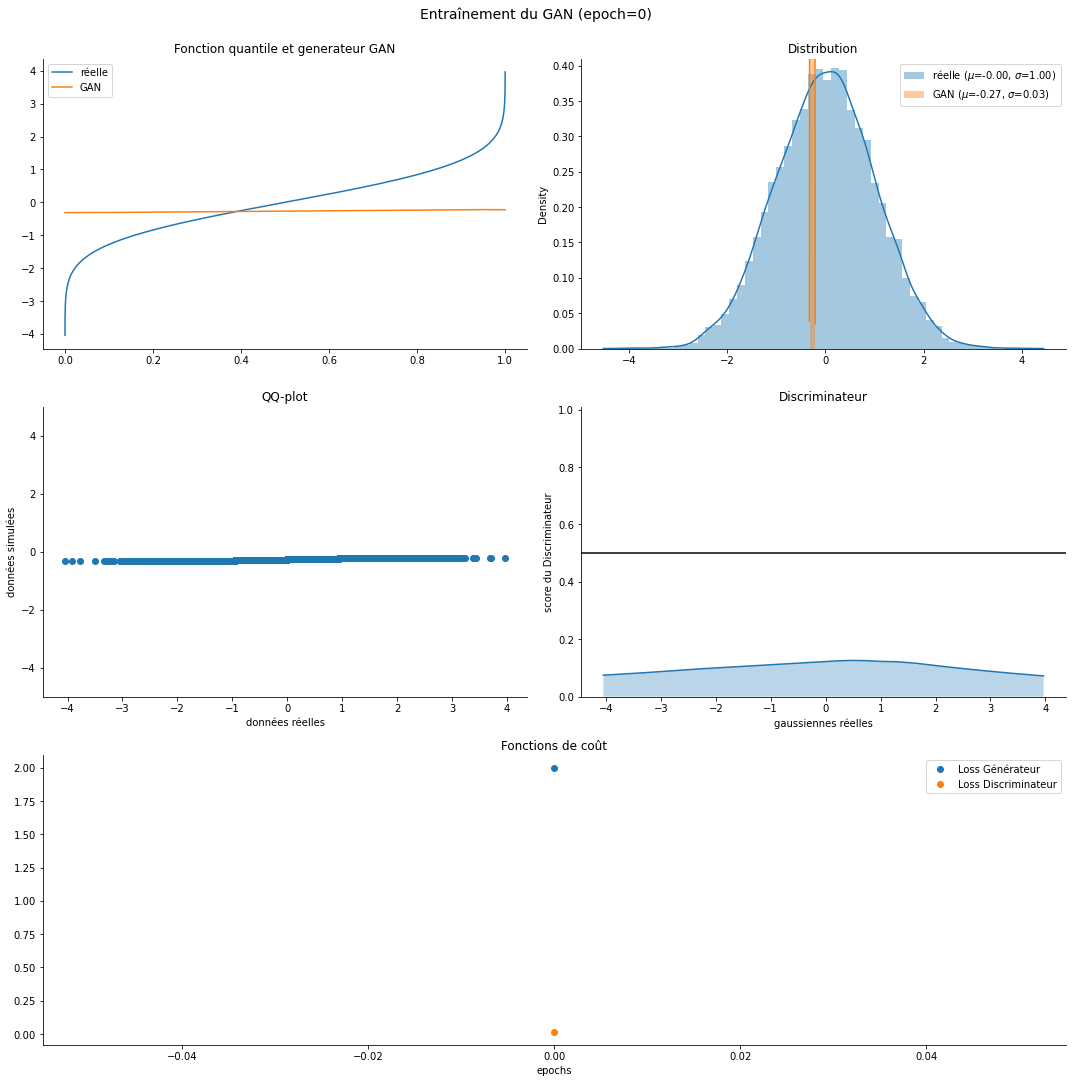

In [64]:
np.random.seed(1234)
noise_test = np.random.uniform(size=(N_DATA, LATENT_DIM))

# évaluation sur toutes les données avec un bruit test fixe
loss_G, loss_D = evaluate(dataset_train, noise_test)  
list_loss_G_train.append(loss_G)
list_loss_D_train.append(loss_D)

# Une autre fonction importée du fichier utils.py
viz_gaussian_gan(noise_test, dataset_train, generator, discriminator, list_loss_G_train, list_loss_D_train, epoch=0)

plt.savefig(os.path.join(path_dir, "imgs", "gaussian", "image_gaussian_N{}-Ldim{}-bs{}_at_epoch_{}.png".format(
    N_DATA, LATENT_DIM, BATCH_SIZE, 0)))

**Entraînement**



In [62]:
# Boucle d'entraînement:
print("Début de l'entraînement ...")

# division des données en batch de taille BATCH_SIZE
data_batches = tf.data.Dataset.from_tensor_slices(dataset_train).batch(BATCH_SIZE)
# np_data_batches = np.stack(list(data_batches))
np_data_batches = list(data_batches.as_numpy_iterator())
# print(np.array(random.sample(list(np_data_batches),1)))
for epoch in range(1, EPOCHS+1):
    start_time= time.time()
    counter_seed+=1
    
#     # mélange des données avec aléa fixé
#     data_shuffle = shuffle(dataset_train, random_state=counter_seed)
#     data_batches = tf.data.Dataset.from_tensor_slices(data_shuffle).batch(BATCH_SIZE)
    
    
    train_step(np_data_batches, LATENT_DIM, batch_size=BATCH_SIZE)
    
    if (epoch) % 10 == 0:    
        # évaluation à epoch modulo 10 sur toutes les données avec un bruit test fixe
        loss_G, loss_D = evaluate(dataset_train, noise_test)  
        list_loss_G_train.append(loss_G)
        list_loss_D_train.append(loss_D)
        
        time_epoch = time.time() - start_time
        display.clear_output(wait=True)
        print("Epoch {} ({:.2f} sec): Loss Generateur={:.5f}, Loss Discriminateur={:.5f}".format(\
            epoch, time_epoch, loss_G, loss_D))

        viz_gaussian_gan(noise_test, dataset_train, generator, discriminator, 
                         list_loss_G_train, list_loss_D_train, epoch)

        # sauvegarde image
        plt.savefig(os.path.join(path_dir, "imgs", "gaussian", "image_gaussian_N{}-Ldim{}-bs{}_at_epoch_{}_on_{}.png"
                                 .format(N_DATA, LATENT_DIM, BATCH_SIZE, epoch, EPOCHS)))
        plt.show()
        
    if (epoch) % (EPOCHS/10) == 0:
        # sauvegarde les modèles 10 fois durant l'entraînement
        generator.save(os.path.join(path_dir, "models", "gaussian", "generator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, EPOCHS, BATCH_SIZE)))
            
        discriminator.save(os.path.join(path_dir,"models", "gaussian", "discriminator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, EPOCHS, BATCH_SIZE)))
        
save_GIF(path_dir, N_DATA, LATENT_DIM, BATCH_SIZE, EPOCHS)   
print("Fin de l'entraînement.")

Epoch 290 (0.02 sec): Loss Generateur=0.01008, Loss Discriminateur=-0.00002


KeyboardInterrupt: 

**Vérification de la valeur optimale théorique**

Rappelons la valeur optimale théorique du GAN 
$$\min_{\theta\in\Theta}\mathcal L\left( \theta, \phi_\theta^\star \right)=-\log(4),$$
avec
$$\mathcal L\left(\theta, \phi \right)=\mathbb E_{x\sim p_r}\left[\log D_\phi(x) \right] + \mathbb E_{z\sim p_Z}\left[\log \left(1 - D_\phi \left(G_\theta(z) \right)\right) \right]$$

In [11]:
def loss_GAN(data, noise, generator, discriminator):
    """
    Fonction de coût originelle du GAN

    Parameters
    ----------
    data: arr
        Données de taille n, x=(x_1,..., x_n)
    noise_test: arr
        Bruit de taille n, z=(z_1,..., z_n)
    generator: tf.Model
        générateur
    discriminator: tf.Model
        discriminateur

    Returns
    -------
    float
        fonction de coût
    """
    
    terme1 = tf.reduce_mean(tf.math.log(tf.nn.sigmoid(discriminator(data))))
    terme2 = tf.reduce_mean(tf.math.log(1. - tf.nn.sigmoid(discriminator(generator(noise_test)))))
    return terme1 + terme2

tf.random.set_seed(1234)
np.random.seed(1234)

LATENT_DIM = 1
noise_test = np.random.uniform(size=(N_DATA, LATENT_DIM))

min_global_pred = loss_GAN(dataset_train, noise_test, generator, discriminator)  # loss après entraînement

print("Dimension latente: {}".format(LATENT_DIM))
print("-"*20)
print("Minimum global du modèle après entraînement = {:.6f}".format(min_global_pred.numpy()))
print("Minimum global théorique = {:.6f}".format(-np.log(4)))

Dimension latente: 1
--------------------
Minimum global du modèle après entraînement = -1.347435
Minimum global théorique = -1.386294


**Modèle pré-entraîné**

Nous avons entraîné le GAN avec plus d'itérations. Pour visualiser le résultat, modifiez dans les fonctions <i>read_GIF_gaussian</i> et <i>read_img_gaussian</i> les paramètres **<i>epochs=1000</i>  et <i>final=True</i>**.

(Commentez la cellule pour arrêter le visionnage)

In [ ]:
# final = False: le modèle que vous avez entrainé
# final = True: le modèle entrainé jusqu'à 1000 époques

# read_GIF_gaussian(n_data=N_DATA, latent_dim=5, epochs=1000, batch_size=BATCH_SIZE,
#                  path_dir=path_dir, final=True)

In [ ]:
# read_img_gaussian(n_data=N_DATA, latent_dim=1, epochs=1000, batch_size=BATCH_SIZE,
#                  path_dir=path_dir, final=True)

### Pour aller plus loin: GAN multi-latent dim

- Modifiez <i>LATENT_DIM=2</i>

- Relancez l'entraînement.

- Visualisez votre entraînement, ainsi que celui du modèle "final" (avec $\text{latent_dim}=2$) entrainé pendant 1000 époques.


**Charger un modèle pré-entraîné**

Vous pouvez charger un modèle avec la fonction <i>"load_model"</i> comme ci-dessous. Pour charger un modèle "final" (= entrainé pendant 1000 époques), entrez <i>"final=True"</i>. (Assurez-vous que le modèle avec les paramètres choisis existe bien dans votre dossier).

Les modèles disponibles sont: $\text{latent_dim}=1,2,5,10$

In [ ]:
generator = load_model_gaussian(n_data=N_DATA, latent_dim=2,
                                    epochs=1000, batch_size=BATCH_SIZE, path_dir=path_dir,
                                    type_model="generator", final=True)

discriminator = load_model_gaussian(n_data=N_DATA, latent_dim=2,
                                    epochs=1000, batch_size=BATCH_SIZE, path_dir=path_dir,
                                    type_model="discriminator", final=True)

In [ ]:
# verification du chargement d'un modèle pré-entraîné:

#np.random.seed(1234)
#LATENT_DIM = ???
#noise = np.random.uniform(size=(1000, LATENT_DIM))
#sns.distplot(generator(noise))

Relancez la vérification de la valeur de la fonction de coût du GAN avec la dimension latente du modèle que vous venez de charger. Que remarquez-vous ?

### Une remarque pour terminer: une autre implémentation de la fonction de coût

Il est également possible de réécrire la fonction de coût en utilisant la cross-entropy binaire:
$$\hat{\mathcal L}(y, \hat{y}) = -\frac{1}{n}\sum_{i=1}^n y_i\log\hat{y}_i + (1-y_i)\log(1-\hat{y}_i)$$

Les fonctions écrites ci-dessous sont par ailleurs souvent préférées dans les applications pour des raisons d'optimisation de temps de calcul.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(fake_output), fake_output))
    total_loss = real_loss + fake_loss
    return total_loss
  
def generator_loss(fake_output):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(fake_output), fake_output))